# Prétraitement des données audio

# Importation des packages

In [1]:
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

# Connection avec Google Drive

Ajoutez un raccourci de ce dossier à votre Google Drive :

https://drive.google.com/drive/folders/1NGH6ntk3qH8Odo7q8YxDS0iqV-httZUR?usp=sharing

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Découverte de la librairie Librosa

Librosa est une bibliothèque qui facilite la manipulation des données audio

In [ ]:
file = "drive/MyDrive/Music_genre_classification/genres_original/pop/pop.00008.wav"

# Importer une musique

Le paramètre `sr` correspond à la fréquence d'échantillonnage, et nous utiliserons 22050 par défaut tout au long de ce TP.

Utilisez la fonction load de la bibliothèque `Librosa` pour importer le fichier `file`.

In [ ]:
signal, sr = librosa.load(file, sr=22050)

# Visualisation de l'onde

Utilisez la fonction `waveshow` de Librosa pour visualiser le signal de l'onde.

Ensuite, servez-vous des fonctions `xlabel` et `ylabel` pour indiquer où se trouvent le temps et l'amplitude sur le graphique.

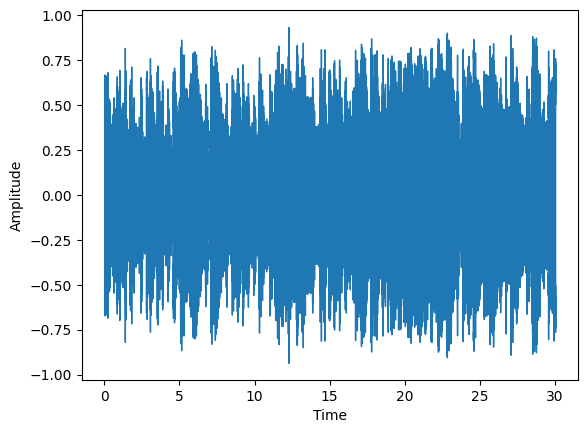

In [ ]:
librosa.display.waveshow(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# La transformée de fourier

Appliquez une transformée de Fourier au signal en utilisant la fonction `fft` de Numpy.

In [ ]:
fft = np.fft.fft(signal)

Utilisez la valeur absolue de la transformée de Fourier pour obtenir la magnitude de l'onde, en vous servant de la fonction `abs` de Numpy.

In [ ]:
magnitude = np.abs(fft)

Utilisez la fonction `linspace` de Numpy pour structurer les fréquences de l'onde.

In [ ]:
frequency = np.linspace(0, sr, len(magnitude))

Visualisation de l'onde dans le domaine fréquence-magnitude.

Utilisez la fonction `plot` de Matplotlib pour tracer le graphique de la magnitude en fonction de la fréquence.

Servez-vous de `xlabel` et `ylabel` pour nommer les axes.

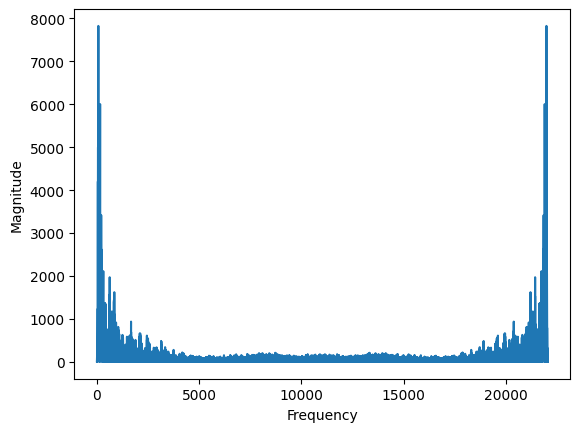

In [ ]:
plt.plot(frequency, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

# Passage au spectrogramme

Utilisez le spectrogramme pour réintégrer la composante temporelle dans la représentation de l'onde.

In [ ]:
 # Number of time for each sample
n_fft=2048

# the amount we slide to the right at each time
hop_length = 512

Appliquez la fonction `core.stft` de Librosa sur le signal.

In [ ]:
stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)

Appliquez la valeur absolue du résultat pour obtenir le spectrogramme, en utilisant la fonction `abs` de Numpy.

In [ ]:
spectogram = np.abs(stft)

Visualisez le spectrogramme à l'aide de la fonction `specshow` de Librosa.

N'oubliez pas d'utiliser `xlabel` et `ylabel` pour nommer les axes.

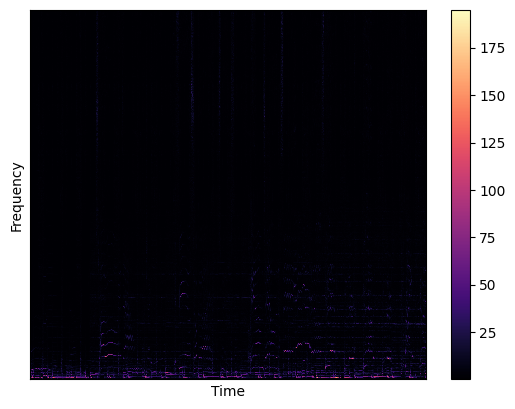

In [ ]:
librosa.display.specshow(spectogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

On ne distingue pas grand-chose.

Appliquez un logarithme aux données du spectrogramme pour obtenir le résultat en décibels, en utilisant la fonction `amplitude_to_db` de Librosa.

In [ ]:
log_spectogram = librosa.amplitude_to_db(spectogram)

Visualisez le résultat, qui devrait être plus facile à lire, en utilisant la fonction `specshow`.

N'oubliez pas d'ajouter les axes avec `xlabel` et `ylabel`.

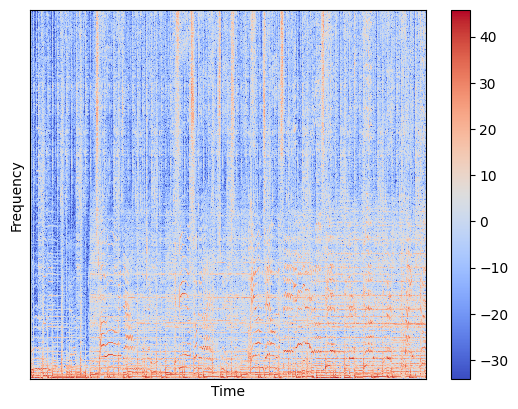

In [ ]:
librosa.display.specshow(log_spectogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

# Le mel frequency cepstral coefficients

Nous pouvons représenter les données audio d'une autre manière en utilisant les MFCCs.

Utilisez la fonction `mfcc` de Librosa pour l'appliquer à notre signal.

Fixez le nombre de composantes `n_mfcc` à 13.

In [ ]:
MFFCs = librosa.feature.mfcc(y=signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

Visualisez le résultat en utilisant la fonction `specshow` de Librosa.

N'oubliez pas d'ajouter les axes avec `ylabel` et `xlabel`.

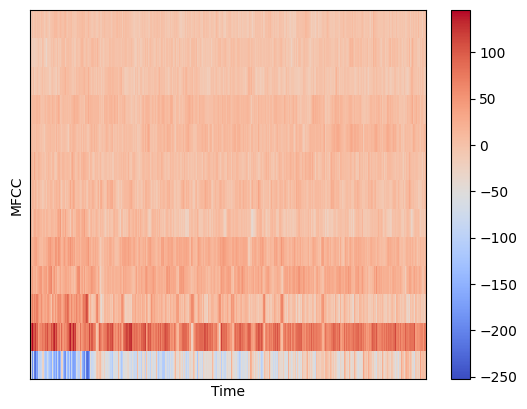

In [ ]:
librosa.display.specshow(MFFCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

# Création du jeu de données

Il est maintenant temps de transformer l'ensemble de notre jeu de données en appliquant la transformation MFCC sur nos pistes, afin d'obtenir des données exploitables pour le deep learning.

Identification des variables globales

In [ ]:
# sample rate
SAMPLE_RATE = 22050

# Longueur de chaque morceau du jeu de données
DURATION = 30

# durée de chaque segment de chanson
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

Votre objectif est de créer une fonction qui prendra un `signal` et le découpera en plusieurs segments pour augmenter artificiellement le nombre d'exemples dans le jeu de données d'entraînement.

`num_segments` divise chaque piste en plusieurs segments musicaux.

`num_samples_per_segment` représente le nombre d'échantillons découpés par segment.

`expected_num_mfcc_vectors_per_segment` correspond au nombre de vecteurs par segment. Il est essentiel d'avoir le même nombre de vecteurs pour chaque segment ; sinon, l'observation ne sera pas sauvegardée.

`data` est le dictionnaire où vous allez stocker vos données. Il contient une clé `mfcc` pour les données MFCC des signaux et une clé `labels` pour le genre de musique associé.

`file_path` désigne le chemin vers le fichier à traiter.

`signal` est le signal à analyser.

`label` représente le genre de musique auquel appartient le signal.

`sample_rate` est la fréquence d'échantillonnage, par défaut fixée à 22050.

`n_fft` correspond à la durée de chaque échantillon, par défaut 2048.

`hop_length` indique le déplacement de la fenêtre entre chaque échantillon, avec pour objectif de créer un recouvrement.

`n_mfcc` est le nombre de composantes que l'on souhaite extraire du signal, par défaut 13.

In [ ]:
def process_segments_from_musics(num_segments:int,
                                 num_samples_per_segment:int,
                                 expected_num_mfcc_vectors_per_segment:int,
                                 data:dict,
                                 file_path:str,
                                 signal:np.ndarray,
                                 label:int,
                                 sample_rate:int=22050,
                                 n_fft:int=2048,
                                 hop_length:int=512,
                                 n_mfcc:int=13)->dict:

  # process segments extracting mfcc and storing data
  for s in range(num_segments):
    start_sample = num_samples_per_segment * s
    finish_sample = start_sample + num_samples_per_segment
    mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                                sr=sample_rate,
                                n_fft=n_fft,
                                n_mfcc=n_mfcc,
                                hop_length=hop_length)

    mfcc = mfcc.T

    # store mfcc for segment if it has the expected length
    if len(mfcc) == expected_num_mfcc_vectors_per_segment:
      data["mfcc"].append(mfcc.tolist())
      data["labels"].append(label-1)
      print("{}, segment:{}".format(file_path, s))

  return data

`num_segments` permet de diviser chaque piste en plusieurs segments musicaux.

`num_samples_per_segment` indique le nombre d'échantillons à découper par segment.

`expected_num_mfcc_vectors_per_segment` représente le nombre de vecteurs par segment. Il est nécessaire d'avoir le même nombre de vecteurs pour chaque segment ; sinon, l'observation ne sera pas sauvegardée.

`data` est le dictionnaire où vous allez stocker vos données. Il contient une clé `mfcc` pour les données MFCC des signaux et une clé `labels` pour le genre de musique associé.

`file_path` désigne le chemin vers le fichier à traiter.

`dirpath` est le chemin vers le dossier à traiter.

`sample_rate` correspond à la fréquence d'échantillonnage, par défaut fixée à 22050.

`n_fft` indique la durée de chaque échantillon, par défaut 2048.

`hop_length` représente le déplacement de la fenêtre entre chaque échantillon, avec pour objectif de créer un recouvrement.

`n_mfcc` est le nombre de composantes que l'on souhaite extraire du signal, par défaut 13.

In [ ]:
def process_musics(num_segments:int,
                   num_samples_per_segment:int,
                   expected_num_mfcc_vectors_per_segment:int,
                   data:dict,
                   filenames:str,
                   dirpath:str,
                   label:int,
                   sample_rate:int=22050,
                   n_fft:int=2048,
                   hop_length:int=512,
                   n_mfcc:int=13)->dict:
  # process files for a specific genre
  for f in filenames:
    # load the audio file
    file_path = os.path.join(dirpath, f)
    signal, _ = librosa.load(file_path, sr=sample_rate)

    data = process_segments_from_musics(num_segments,
                                        num_samples_per_segment,
                                        expected_num_mfcc_vectors_per_segment,
                                        data,
                                        file_path,
                                        signal,
                                        label,
                                        sample_rate,
                                        n_fft,
                                        hop_length,
                                        n_mfcc)

  return data

`num_segments` permet de diviser chaque piste en plusieurs segments musicaux.

`num_samples_per_segment` indique le nombre d'échantillons à découper par segment.

`expected_num_mfcc_vectors_per_segment` représente le nombre de vecteurs par segment. Il est essentiel d'avoir le même nombre de vecteurs pour chaque segment ; sinon, l'observation ne sera pas sauvegardée.

`data` est le dictionnaire où vous allez stocker vos données. Il contient une clé `mfcc` pour les données MFCC des signaux et une clé `labels` pour le genre de musique associé. Une clé `mapping` contiendra un vecteur avec les différents genres écrits, associés au label par leur indice.

`dataset_path` désigne le chemin vers les dossiers de genres musicaux à traiter.

`sample_rate correspond` à la fréquence d'échantillonnage, par défaut fixée à 22050.

`n_fft` indique la durée de chaque échantillon, par défaut 2048.

`hop_length` représente le déplacement de la fenêtre entre chaque échantillon, avec pour objectif de créer un recouvrement.

`n_mfcc` est le nombre de composantes que l'on souhaite extraire du signal, par défaut 13.

In [ ]:
def process_musics_gender(num_segments:int,
                          num_samples_per_segment:int,
                          expected_num_mfcc_vectors_per_segment:int,
                          data:dict,
                          dataset_path:str,
                          sample_rate:int=22050,
                          n_fft:int=2048,
                          hop_length:int=512,
                          n_mfcc:int=13)->dict:
  # Loop through all the genres
  for label, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
    # ensure that we're not at the root level
    if dirpath is not dataset_path:
      # save the semantic label
      dirpath_components = dirpath.split("/")
      semantic_label = dirpath_components[-1]
      data["mapping"].append(semantic_label)
      print('\nProcessing {}'.format(semantic_label))
      data = process_musics(num_segments,
                            num_samples_per_segment,
                            expected_num_mfcc_vectors_per_segment,
                            data,
                            filenames,
                            dirpath,
                            label,
                            sample_rate,
                            n_fft,
                            hop_length,
                            n_mfcc)
  return data


`dataset_path` désigne le chemin vers les dossiers contenant les genres musicaux à traiter.

`json_path` est le chemin où sera sauvegardé le fichier JSON contenant toutes les données traitées.

`sample_rate` correspond à la fréquence d'échantillonnage, par défaut fixée à 22050.

`n_fft` indique la durée de chaque échantillon, par défaut 2048.

`hop_length` représente le déplacement de la fenêtre entre chaque échantillon, avec pour objectif de créer un recouvrement.

`n_mfcc` est le nombre de composantes que l'on souhaite extraire du signal, par défaut 13.

`num_segments` permet de diviser chaque piste en plusieurs segments musicaux

In [ ]:
def save_mfcc(dataset_path:str,
              json_path:str,
              sample_rate:int=22050,
              n_fft:int=2048,
              hop_length:int=512,
              n_mfcc:int=13,
              num_segments:int=5)->None:
  # dictionary to store data
  data = {
      "mapping": [],
      "labels": [],
      "mfcc": []
  }

  num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
  expected_num_mfcc_vectors_per_segment = np.ceil(num_samples_per_segment / hop_length)

  data = process_musics_gender(num_segments,
                               num_samples_per_segment,
                               expected_num_mfcc_vectors_per_segment,
                               data,
                               dataset_path,
                               sample_rate,
                               n_fft,
                               hop_length,
                               n_mfcc)

  with open(json_path, "w") as fp:
    json.dump(data, fp, indent=4)


Applliquez les fonction sur le jeu de données

In [ ]:
save_mfcc(dataset_path="drive/MyDrive/Music_genre_classification/genres_original/",
 json_path="drive/MyDrive/Music_genre_classification/data.json",
 num_segments=10)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
drive/MyDrive/Music_genre_classification/genres_original/reggae/reggae.00003.wav, segment:6
drive/MyDrive/Music_genre_classification/genres_original/reggae/reggae.00003.wav, segment:7
drive/MyDrive/Music_genre_classification/genres_original/reggae/reggae.00003.wav, segment:8
drive/MyDrive/Music_genre_classification/genres_original/reggae/reggae.00003.wav, segment:9
drive/MyDrive/Music_genre_classification/genres_original/reggae/reggae.00000.wav, segment:0
drive/MyDrive/Music_genre_classification/genres_original/reggae/reggae.00000.wav, segment:1
drive/MyDrive/Music_genre_classification/genres_original/reggae/reggae.00000.wav, segment:2
drive/MyDrive/Music_genre_classification/genres_original/reggae/reggae.00000.wav, segment:3
drive/MyDrive/Music_genre_classification/genres_original/reggae/reggae.00000.wav, segment:4
drive/MyDrive/Music_genre_classification/genres_original/reggae/reggae.00000.wav, segment:5
dr

# Entraînement du modèle

## Création du générateur

Créez une fonction génératrice qui va lire votre fichier JSON et séparer les entrées, qui sont les MFCC extraits, des cibles, qui correspondent aux genres de musique associés.

In [ ]:
def load_data(dataset_path:str):
  with open(dataset_path, "r") as fp:
    data = json.load(fp)

    # Convert lists into numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    return inputs, targets

Chargez le jeu de données

In [ ]:
inputs, targets = load_data("drive/MyDrive/Music_genre_classification/data.json")

## Séparation du jeu de données d'entraînement et de test

Utilisez la fonction `train_test_split` de Scikit-learn pour diviser le jeu de données en deux parties.

Appliquez un coefficient de 30 % pour le jeu de test.

In [ ]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs,
                                                                          targets,
                                                                          test_size=0.3)

## Initialisation du modèle

Vous allez créer une fonction `build_model` qui prend en entrée la dimension d'entrée du modèle, `inputs_shape`, et qui va construire l'architecture suivante à l'aide de la fonction `Sequential` :

- Une couche de `Flatten` pour transformer vos spectrogrammes en vecteurs.
- Une couche de neurones entièrement connectés, utilisant la fonction `Dense`, avec 512 neurones et la fonction d'activation ReLU.
- Une autre couche de neurones entièrement connectés, avec 256 neurones et la fonction d'activation ReLU.
- Une couche supplémentaire de neurones entièrement connectés, avec 64 neurones et la fonction d'activation ReLU.
- Enfin, une couche de sortie de neurones entièrement connectés, avec 10 neurones et la fonction d'activation softmax.

In [ ]:
def build_model(inputs_shape:tuple):
    # build the network architecture
    model = keras.Sequential([
        # input layer
        keras.layers.Flatten(input_shape=(inputs_shape[1], inputs_shape[2])),
        # 1st hidden layer
        keras.layers.Dense(512, activation="relu"),
        # 2nd hidden layer
        keras.layers.Dense(256, activation="relu"),
        # 3rd hidden layer
        keras.layers.Dense(64, activation="relu"),
        # output layer
        keras.layers.Dense(10, activation="softmax")
    ])
    return model

Utilisez la fonction que vous avez écrite précédemment pour initialiser votre modèle.

In [ ]:
model = build_model(inputs.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Choisir l'algorithme d'optimisation

Utilisez l'algorithme d'optimisation `Adam` avec un learning rate de 0.0001

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

## Compilation du modèle

Utilisez la méthode `compile`pour compiler le modèle avec pour fonction de coût `sparse_categorical_crossentropy` et comme mètrique `accuracy`.

In [ ]:
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

## Visualisation du modèle

Visualisez du modèle grâce à la méthode `summary`

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 1690)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         865,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,014,218 (3.87 MB)

 Trainable params: 1,014,218 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

## Entraînement du modèle

Entraînez le modèle en utilisant la méthode `fit`. Spécifiez un jeu de données de validation dans validation_data, un nombre d'époques (`epochs`) de 50, et une taille du batch (`batch_size`) de 32.

In [ ]:
# train network
history = model.fit(inputs_train, targets_train, validation_data=(inputs_test, targets_test), epochs=50, batch_size=32)

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.2685 - loss: 13.8731 - val_accuracy: 0.2447 - val_loss: 2.4346
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.3174 - loss: 2.0884 - val_accuracy: 0.3241 - val_loss: 2.0241
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.3904 - loss: 1.7720 - val_accuracy: 0.3528 - val_loss: 1.9597
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4180 - loss: 1.6881 - val_accuracy: 0.3658 - val_loss: 1.9235
Epoch 5/50
 40/219 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4859 - loss: 1.5527

KeyboardInterrupt: 

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [ ]:
# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(inputs_test, targets_test, verbose=2)
print('\nTest accuracy:', test_acc)

# Utilisation de l'architecture Convolutional Neural Network (CNN)

## Transformation du son en image

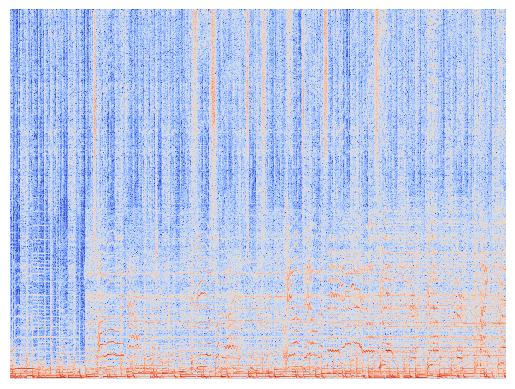

In [ ]:
file = "drive/MyDrive/Music_genre_classification/genres_original/pop/pop.00008.wav"

signal, sr = librosa.load(file, sr=22050)

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)

spectogram = np.abs(stft)

log_spectogram = librosa.amplitude_to_db(spectogram)

# Affichez le spectrogramme
librosa.display.specshow(log_spectogram, sr=sr, hop_length=hop_length)

# Masque les axes si vous le souhaitez
plt.axis('off')

# Sauvegardez la figure sans contour blanc
plt.savefig('pop.00008.png', bbox_inches='tight', pad_inches=0)

## Visualisation des spectogrammes

(288, 432, 4)


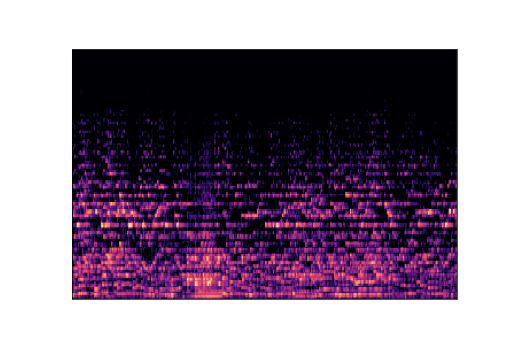

In [ ]:
img = mpimg.imread("drive/MyDrive/Music_genre_classification/images_original/train/classical/classical00002.png")

print(img.shape)

plt.imshow(img)

# Masque les axes si vous le souhaitez
plt.axis('off')

plt.show()

In [ ]:
image_shape = img.shape

## Créer le générateur

Utilisez la classe *ImageDataGenerator* pour initialiser le générateur.

N'hésitez pas à chercher de l'aide dans la [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Vous n'allez pas charger directement toutes les images en mémoire pendant l'entraînement. Vous allez utilisez la fonction *flow_from_directory* pour renseigner l'endroit ou se trouve vos images. Les images seront lu batch par batch.

Utilisez :
- un batch de 32 ;
- une taille d'image de 150x150
- autoriser le mélange des images à chaque époque.

N'hésitez pas à vous aidez de la [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory).

In [ ]:
train_gen = train_datagen.flow_from_directory(
directory='drive/MyDrive/Music_genre_classification/images_original/train/',
target_size=(288, 432),
batch_size=32,
class_mode='categorical',
shuffle=True)

Found 799 images belonging to 10 classes.


In [ ]:
val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_directory(
    directory='drive/MyDrive/Music_genre_classification/images_original/val/',
    target_size=(288, 432),
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

Found 200 images belonging to 10 classes.


Créer un générateur keras

In [ ]:
input_shape = (image_shape[0], image_shape[1], 3)

Initialisation du modèle

In [ ]:
def build_model(inpust_shape):
  # create model
  model = keras.Sequential()

  model.add(keras.layers.Input(input_shape))

  # 1st conv layer
  model.add(keras.layers.Conv2D(32, (3, 3), activation="relu"))
  model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding="same"))
  #model.add(keras.layers.BatchNormalization())

  # 2nd conv layer
  model.add(keras.layers.Conv2D(64, (3, 3), activation="relu"))
  model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding="same"))
  #model.add(keras.layers.BatchNormalization())

  ## 3rd conv layer
  model.add(keras.layers.Conv2D(128, (3, 3), activation="relu"))
  model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding="same"))
  #model.add(keras.layers.BatchNormalization())

  # flattent the output and feed it into dense layer
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(64, activation = "relu"))
  model.add(keras.layers.Dropout(0.3))

  # Output layer
  model.add(keras.layers.Dense(10, activation="softmax"))

  return model

In [ ]:
  # Build the CNN net
  model = build_model(input_shape)

Choisir l'algorithme d'optimisation

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

Compilation du modèle

In [ ]:
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

Visualisation du modèle

In [ ]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 286, 430, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 143, 215, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 141, 213, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 71, 107, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 69, 105, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 35, 53, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 237440)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │      15,196,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,290,122 (58.33 MB)

 Trainable params: 15,290,122 (58.33 MB)

 Non-trainable params: 0 (0.00 B)

Entraînement du modèle

In [ ]:
history = model.fit(train_gen,
          validation_data=val_gen,
          batch_size=32,
          epochs=30)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 8/25 ━━━━━━━━━━━━━━━━━━━━ 2:52 10s/step - accuracy: 0.1405 - loss: 99.5375 

KeyboardInterrupt: 

Visualisation de l'entraînement

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [ ]:
# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_error, test_accuracy = model.evaluate(val_gen, verbose=1)
print("Accuracy on test set is: {}".format(test_accuracy))

# RNN

Création du générateur

In [6]:
def load_data(dataset_path:str):
  with open(dataset_path, "r") as fp:
    data = json.load(fp)

    # Convert lists into numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    return inputs, targets

In [7]:
def prepare_datasets(test_size, validation_data, data_path):
  # Load data
  x, y = load_data(data_path)

  # Create train/test split
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

  # Create train/validation split
  x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=validation_data)

  return x_train, x_validation, x_test, y_train, y_validation, y_test


In [8]:
# create train, validation and test set
x_train, x_validation, x_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2, "drive/MyDrive/Music_genre_classification/genres_original/data.json")
input_shape = (x_train.shape[1], x_train.shape[2])

Intiialisation du modèle

In [15]:
def build_model(inpust_shape):
  # create model
  model = keras.Sequential()

  model.add(keras.layers.Input(input_shape))

  # 2 LSTM layers
  model.add(keras.layers.LSTM(64, return_sequences=True))
  model.add(keras.layers.LSTM(64))

  # dense layer
  model.add(keras.layers.Dense(64, activation = "relu"))

  # Output layer
  model.add(keras.layers.Dense(10, activation="softmax"))

  return model

In [16]:
  # Build the CNN net
  model = build_model(input_shape)

Choix de l'optimisateur

In [17]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

Compilation du modèle

In [18]:
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

Visualisation du modèle

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 130, 64)             │          19,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,802 (225.79 KB)

 Trainable params: 57,802 (225.79 KB)

 Non-trainable params: 0 (0.00 B)

Entraînement du modèle

In [20]:
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=32, epochs=50)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.1614 - loss: 2.2699 - val_accuracy: 0.3685 - val_loss: 2.0401
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.3585 - loss: 1.9521 - val_accuracy: 0.4112 - val_loss: 1.6924
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4270 - loss: 1.6473 - val_accuracy: 0.4466 - val_loss: 1.5371
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4726 - loss: 1.4818 - val_accuracy: 0.4686 - val_loss: 1.4526
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5115 - loss: 1.3794 - val_accuracy: 0.4853 - val_loss: 1.4120
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5341 - loss: 1.3083 - val_accuracy: 0.5040 - val_loss: 1.3562
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5501 - loss: 1.2511 - val_accuracy: 0.5194 - val_loss: 1.3089
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5919 - loss: 1.1828 - val_accu

Visualisation des performances lors de l'entraînement

In [21]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

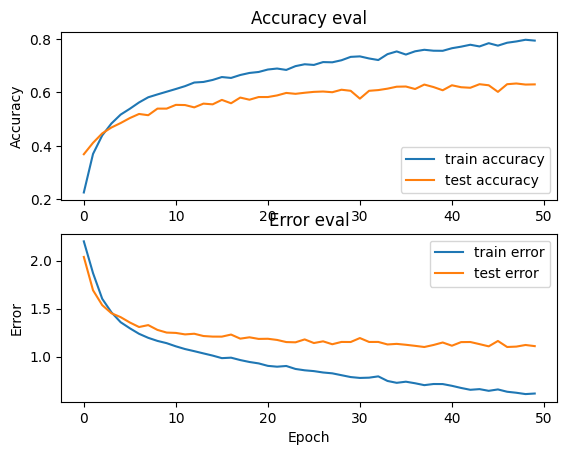

79/79 - 1s - 8ms/step - accuracy: 0.6448 - loss: 1.0866

Test accuracy: 0.6447737216949463


In [22]:
# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)